In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV, KFold

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data = pd.read_csv("/content/Aviation_KPIs_Data.csv")

In [9]:
data.columns = data.columns.str.strip()

In [10]:
print(data.head())

  Flight Number Scheduled Departure Time Actual Departure Time  \
0         FL885      2024-05-20 11:51:21   2024-07-10 02:38:54   
1         FL930      2024-01-23 06:56:23   2024-07-07 02:53:44   
2         FL478      2024-05-30 09:18:39   2024-12-05 01:00:54   
3         FL637      2024-08-15 05:21:47   2024-09-21 13:23:42   
4         FL318      2024-07-25 15:29:58   2024-03-21 15:05:54   

   Delay (Minutes)  Aircraft Utilization (Hours/Day)  \
0               50                             12.36   
1               27                             14.53   
2              108                             10.73   
3               64                             15.10   
4               30                             13.46   

   Turnaround Time (Minutes)  Load Factor (%)  Fleet Availability (%)  \
0                        115            79.18                   96.24   
1                         83            98.59                   80.49   
2                         87            67.44  

In [11]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171083 entries, 0 to 171082
Data columns (total 18 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Flight Number                     171083 non-null  object 
 1   Scheduled Departure Time          171083 non-null  object 
 2   Actual Departure Time             171083 non-null  object 
 3   Delay (Minutes)                   171083 non-null  int64  
 4   Aircraft Utilization (Hours/Day)  171083 non-null  float64
 5   Turnaround Time (Minutes)         171083 non-null  int64  
 6   Load Factor (%)                   171083 non-null  float64
 7   Fleet Availability (%)            171083 non-null  float64
 8   Maintenance Downtime (Hours)      171083 non-null  float64
 9   Fuel Efficiency (ASK)             171083 non-null  float64
 10  Revenue (USD)                     171083 non-null  float64
 11  Operating Cost (USD)              171083 non-null  f

In [12]:
print(data.describe())

       Delay (Minutes)  Aircraft Utilization (Hours/Day)  \
count    171083.000000                     171083.000000   
mean         59.346294                         12.006356   
std          34.695308                          2.312283   
min           0.000000                          8.000000   
25%          29.000000                         10.000000   
50%          59.000000                         12.010000   
75%          89.000000                         14.010000   
max         119.000000                         16.000000   

       Turnaround Time (Minutes)  Load Factor (%)  Fleet Availability (%)  \
count              171083.000000    171083.000000           171083.000000   
mean                   74.457690        74.984518               85.019963   
std                    25.964138        14.452449                8.671978   
min                    30.000000        50.000000               70.000000   
25%                    52.000000        62.480000               77.490000 

In [13]:
missing = data.isnull().sum()
print("Missing values:\n", missing)

Missing values:
 Flight Number                       0
Scheduled Departure Time            0
Actual Departure Time               0
Delay (Minutes)                     0
Aircraft Utilization (Hours/Day)    0
Turnaround Time (Minutes)           0
Load Factor (%)                     0
Fleet Availability (%)              0
Maintenance Downtime (Hours)        0
Fuel Efficiency (ASK)               0
Revenue (USD)                       0
Operating Cost (USD)                0
Net Profit Margin (%)               0
Ancillary Revenue (USD)             0
Debt-to-Equity Ratio                0
Revenue per ASK                     0
Cost per ASK                        0
Profit (USD)                        1
dtype: int64


In [14]:
print(data.columns)

Index(['Flight Number', 'Scheduled Departure Time', 'Actual Departure Time',
       'Delay (Minutes)', 'Aircraft Utilization (Hours/Day)',
       'Turnaround Time (Minutes)', 'Load Factor (%)',
       'Fleet Availability (%)', 'Maintenance Downtime (Hours)',
       'Fuel Efficiency (ASK)', 'Revenue (USD)', 'Operating Cost (USD)',
       'Net Profit Margin (%)', 'Ancillary Revenue (USD)',
       'Debt-to-Equity Ratio', 'Revenue per ASK', 'Cost per ASK',
       'Profit (USD)'],
      dtype='object')


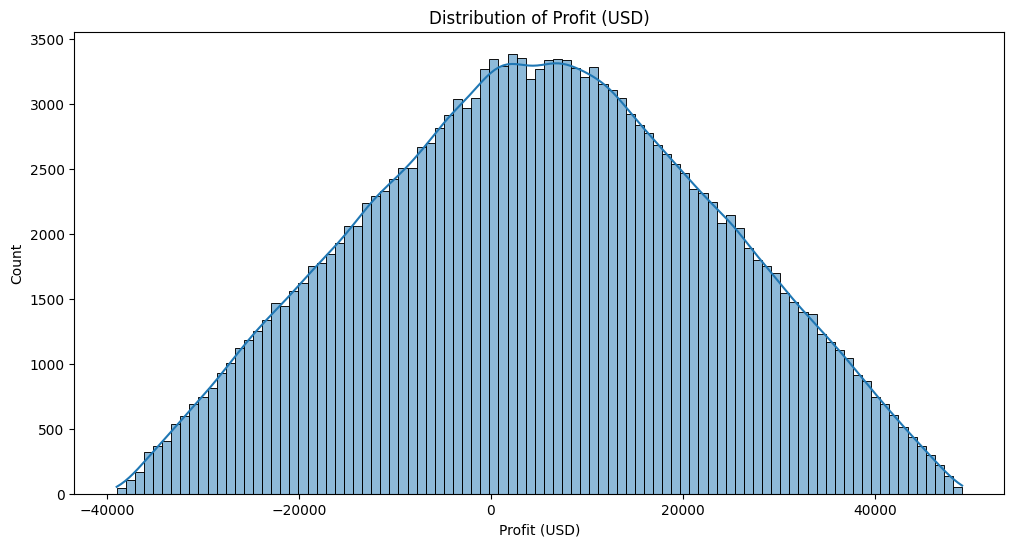

In [15]:
plt.figure(figsize=(12, 6))
sns.histplot(data['Profit (USD)'], kde=True)
plt.title('Distribution of Profit (USD)')
plt.show()

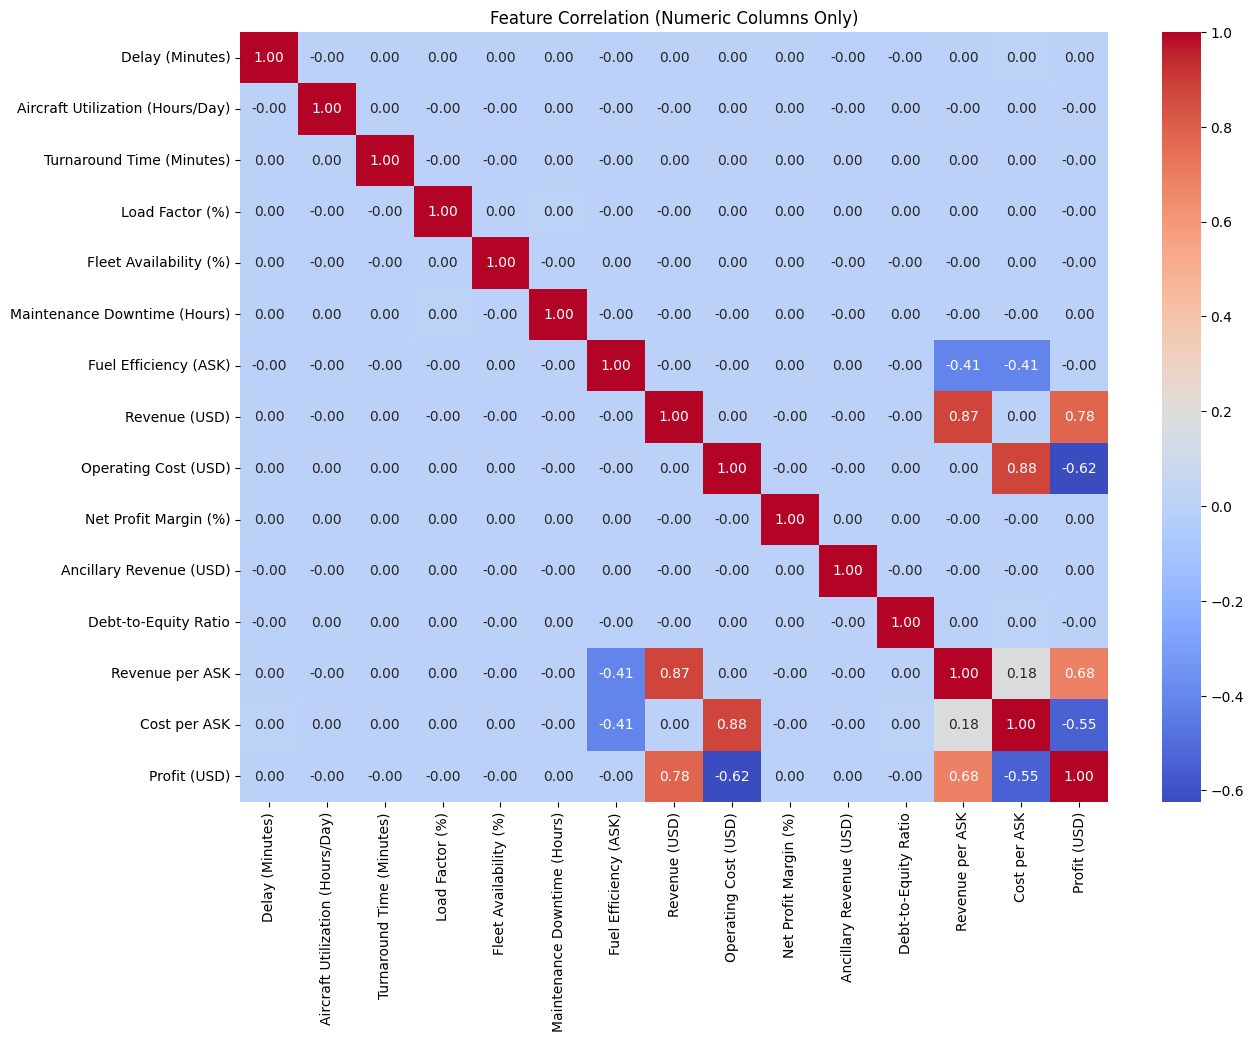

In [16]:
plt.figure(figsize=(14, 10))
numeric_corr = data.select_dtypes(include=[np.number]).corr()
sns.heatmap(numeric_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation (Numeric Columns Only)')
plt.show()

In [17]:
# Data Cleaning > Fill missing numeric values with the median
for col in data.select_dtypes(include=np.number).columns:
    data[col].fillna(data[col].median(), inplace=True)

<ipython-input-17-9ff9813851f9>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)


In [18]:
# Inspecting categorical columns and their cardinality
categorical_cols = data.select_dtypes(include='object').columns
print("Unique values in each categorical column:")
print(data[categorical_cols].nunique())

Unique values in each categorical column:
Flight Number                 1000
Scheduled Departure Time    170583
Actual Departure Time       170624
dtype: int64


In [19]:
print(data.isnull().sum())

Flight Number                       0
Scheduled Departure Time            0
Actual Departure Time               0
Delay (Minutes)                     0
Aircraft Utilization (Hours/Day)    0
Turnaround Time (Minutes)           0
Load Factor (%)                     0
Fleet Availability (%)              0
Maintenance Downtime (Hours)        0
Fuel Efficiency (ASK)               0
Revenue (USD)                       0
Operating Cost (USD)                0
Net Profit Margin (%)               0
Ancillary Revenue (USD)             0
Debt-to-Equity Ratio                0
Revenue per ASK                     0
Cost per ASK                        0
Profit (USD)                        0
dtype: int64


In [20]:
# --- Feature Engineering ---
# (1) Capture Seasonal Fluctuations: Extract month, day, and hour from scheduled departure time.
# If the column 'Scheduled Departure Time' is in a string format, convert it to datetime first.
if 'Scheduled Departure Time' in data.columns:
    try:
        data['Scheduled Departure Time'] = pd.to_datetime(data['Scheduled Departure Time'])
        data['Departure_Month'] = data['Scheduled Departure Time'].dt.month
        data['Departure_Day'] = data['Scheduled Departure Time'].dt.day
        data['Departure_Hour'] = data['Scheduled Departure Time'].dt.hour
    except Exception as e:
        print("Error parsing Scheduled Departure Time:", e)

In [21]:
# (2) Operational Insights
# Example > cost efficiency ratio = Operating Cost / Revenue
data['Cost_Efficiency'] = data.apply(lambda row: row['Operating Cost (USD)'] / row['Revenue (USD)']
                                     if row['Revenue (USD)'] != 0 else np.nan, axis=1)
data['Cost_Efficiency'].fillna(data['Cost_Efficiency'].median(), inplace=True)

<ipython-input-21-e9a6516f20f6>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Cost_Efficiency'].fillna(data['Cost_Efficiency'].median(), inplace=True)


In [22]:
# (3) Dropping high-cardinality columns that are less informative:
high_card_cols = ['Flight Number', 'Actual Departure Time']  # Already used Scheduled Departure Time for features
data.drop(columns=high_card_cols, inplace=True, errors='ignore')

In [23]:
# Update categorical_cols after dropping high-cardinality
categorical_cols = data.select_dtypes(include='object').columns # This line updates categorical_cols

In [24]:
# One-hot encode remaining categorical columns (if any)
if len(categorical_cols) > 0:
    data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [25]:
# Identify high-cardinality columns (e.g., Flight Number, Scheduled Departure Time, Actual Departure Time)
# These columns can lead to memory issues if one-hot encoded directly.
high_cardinality_cols = ['Flight Number', 'Scheduled Departure Time', 'Actual Departure Time']

In [26]:
# Drop these high-cardinality columns or extract useful features from them.
data.drop(columns=high_cardinality_cols, inplace=True, errors='ignore')

In [27]:
# Updating categorical columns after dropping high-cardinality
categorical_cols = data.select_dtypes(include='object').columns

In [28]:
# One-hot encode of remaining categorical columns
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [29]:
# Defining features x and target y
X = data.drop('Profit (USD)', axis=1)
y = data['Profit (USD)']

In [30]:
# --- Train-Test Split (80/20 split) ---
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Baseline Model: Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [32]:
# Defining the base model
rf = RandomForestRegressor(random_state=42)
# Defining a smaller hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# Use 2-fold cross-validation to reduce the number of fits
cv = KFold(n_splits=2, shuffle=True, random_state=42)

# Use RandomizedSearchCV with fewer iterations (e.g., 3) for initial tuning
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=3,  # Try 3 random combinations initially
    scoring='neg_mean_squared_error',
    n_jobs=4,  # Adjust this as needed
    cv=cv,
    verbose=2,
    random_state=42
)

# Subsample the training data for tuning (e.g., 50,000 rows)
X_train_sample = X_train.sample(n=50000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# Fit the randomized search on the sample
%time random_search.fit(X_train_sample, y_train_sample)
best_rf = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)


Fitting 2 folds for each of 3 candidates, totalling 6 fits
CPU times: user 3min 37s, sys: 1.29 s, total: 3min 38s
Wall time: 8min 48s
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 20}


In [33]:
#Evaluating the Model ---
y_pred_rf = best_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

In [34]:
print("Random Forest Performance:")
print("RMSE:", rmse_rf)
print("MAE:", mae_rf)
print("R²:", r2_rf)

Random Forest Performance:
RMSE: 73.6864697425223
MAE: 52.06551826969687
R²: 0.9999835719406176
